In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


In [4]:
path_list = os.listdir('rooms_dataset')

In [5]:
room_types = os.listdir('rooms_dataset')
print (room_types)  #what kinds of rooms are in this dataset

print("Types of rooms found: ", len(room_types))

['bathroom', 'bedroom', 'Diningroom', 'kitchen', 'livingroom']
Types of rooms found:  5


In [7]:
rooms = []

for item in room_types:
    all_rooms = os.listdir('rooms_dataset' + '/' +item)
    for room in all_rooms:
        rooms.append((item, str('rooms_dataset' + '/' +item) + '/' + room))
    #print(rooms[:1])

rooms[:5]

[('bathroom', 'rooms_dataset/bathroom/1.jpg'),
 ('bathroom', 'rooms_dataset/bathroom/10.jpg'),
 ('bathroom', 'rooms_dataset/bathroom/11.jpg'),
 ('bathroom', 'rooms_dataset/bathroom/12.jpg'),
 ('bathroom', 'rooms_dataset/bathroom/13.jpg')]

In [8]:
rooms_df = pd.DataFrame(data=rooms, columns=['room type', 'image'])
print(rooms_df.head())

  room type                          image
0  bathroom   rooms_dataset/bathroom/1.jpg
1  bathroom  rooms_dataset/bathroom/10.jpg
2  bathroom  rooms_dataset/bathroom/11.jpg
3  bathroom  rooms_dataset/bathroom/12.jpg
4  bathroom  rooms_dataset/bathroom/13.jpg


In [9]:
print("Total number of rooms in the dataset: ", len(rooms_df))

room_count = rooms_df['room type'].value_counts()

print("rooms in each category: ")
print(room_count)

Total number of rooms in the dataset:  87
rooms in each category: 
kitchen       25
bathroom      16
Diningroom    16
livingroom    16
bedroom       14
Name: room type, dtype: int64


In [14]:
rooms_df

,room type,image
0,bathroom,rooms_dataset/bathroom/1.jpg
1,bathroom,rooms_dataset/bathroom/10.jpg
2,bathroom,rooms_dataset/bathroom/11.jpg
3,bathroom,rooms_dataset/bathroom/12.jpg
4,bathroom,rooms_dataset/bathroom/13.jpg
...,...,...
82,livingroom,rooms_dataset/livingroom/5.jpg
83,livingroom,rooms_dataset/livingroom/6.jpg
84,livingroom,rooms_dataset/livingroom/7.jpg
85,livingroom,rooms_dataset/livingroom/8.jpg


In [13]:
import cv2

In [19]:
images =[]
im_size=224
for i in range(len(rooms_df)):
    img = cv2.imread(rooms_df.iloc[i,1])
    img = cv2.resize(img,(im_size,im_size))
    images.append(img)
labels= rooms_df['room type']

In [20]:
images = np.array(images)
images.shape

(87, 224, 224, 3)

In [21]:
images = images.astype('float32')

In [27]:
from sklearn.preprocessing import OneHotEncoder
y = np.array(labels)
oe = OneHotEncoder()
y_transformed = oe.fit_transform(y.reshape(-1,1))

In [29]:
y_transformed.shape

(87, 5)

In [32]:
X = images
X.shape

(87, 224, 224, 3)

# ResNet

In [30]:
import numpy as np
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.initializers import glorot_uniform
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)


Using TensorFlow backend.


In [33]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE ###
    
    return X

In [34]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f ,f), strides = (1,1), name = conv_name_base + '2b', 
               kernel_initializer = glorot_uniform(seed=0),padding ='same')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', 
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [35]:

def ResNet50(input_shape = (224, 224, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X,  3,  [128,128,512], stage = 3, block='b')
    X = identity_block(X,  3, [128,128,512], stage = 3, block='c')
    X = identity_block(X,3, [128,128,512], stage = 3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block='a', s = 2)
    X = identity_block(X,  3,  [256,256,1024], stage = 4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block='e')
    X = identity_block(X,  3,[256,256,1024], stage = 4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage = 5, block='b')
    X = identity_block(X,3, [512,512,2048], stage = 5, block='c')
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [36]:
model = ResNet50(input_shape = (224, 224, 3), classes = 5)


In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [41]:
model.fit(X,y_transformed, epochs = 3, batch_size = 32)

Epoch 1/3
87/87 [==============================] - 108s 1s/step - loss: 13.6428 - accuracy: 0.1839
Epoch 2/3
87/87 [==============================] - 84s 971ms/step - loss: 9.0949 - accuracy: 0.2529
Epoch 3/3
87/87 [==============================] - 77s 880ms/step - loss: 2.5654 - accuracy: 0.2644


Input image shape: (1, 224, 224, 3)
[[0. 0. 0. 1. 0.]]


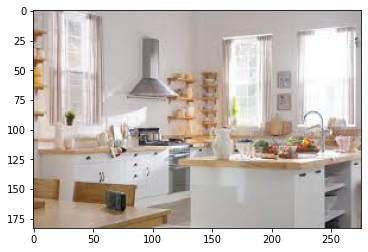

In [43]:
from matplotlib.pyplot import imread
img_path = 'test_image.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
print(model.predict(x))